In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import pydicom as pdcm
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import ndimage

%env WANDB_DISABLED=True

2021-10-03 12:15:43.924763: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


env: WANDB_DISABLED=True


In [2]:
train_labels=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
model_weights='../input/brain-tumor-3d-weights/Brain_3d_cls_FLAIR.h5'

In [3]:
train_labels.head(20)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


In [4]:
sample_df=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')

In [5]:
sample_df.head(3)

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5


In [6]:
# drop some rows of the train_labels data as these
# are corrupted
for id in [109, 123, 709]:
    train_labels.drop(train_labels[train_labels["BraTS21ID"]==id].index, inplace=True)

<AxesSubplot:>

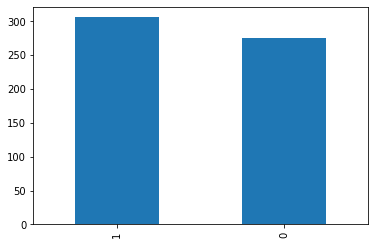

In [7]:
train_labels['MGMT_value'].value_counts().plot.bar()

In [8]:
main_path='../input/rsna-miccai-brain-tumor-radiogenomic-classification'

In [9]:
# set seed
random.seed(123)
np.random.seed(345)
tf.random.set_seed(125)

In [10]:
mri_types=['FLAIR','T1wCE','T2w','T1w']

In [11]:
#tf.reshape(tf.stack([[[[2,3],[4,5]]],[[[10,12],[13,15]]]],axis=0),shape=(-1,2,2))

In [12]:
def read_dicom_img(dataset_dir, file_id,max_samples=20,img_size=256):
    file_path = f"{main_path}/{dataset_dir}/{str(file_id).zfill(5)}"
    final_img = {'FLAIR':[], 'T1w':[], 'T1wCE':[], 'T2w':[]}
            
    for mri_type in mri_types:
        final_file_path = f"{file_path}/{mri_type}"
        files= tf.random.shuffle(os.listdir(final_file_path),seed=45).numpy().tolist()
        #files= os.listdir(final_file_path)

        for image_file in files[:max_samples]:
            data = pdcm.dcmread(f"{final_file_path}/{image_file.decode('utf-8')}")
            #data = pdcm.dcmread(f"{final_file_path}/{image_file}")
            img_data = data.pixel_array
            img_data = cv2.resize(img_data, (img_size,img_size))
            img_data=img_data.astype("float32")
            
            #if np.min(img_data) < np.max(img_data):
                #img_data = (img_data - np.min(img_data))/(np.max(img_data))
            if np.max(img_data)!=0:
                if np.min(img_data)<np.max(img_data):
                    img_data=(img_data-np.min(img_data))/np.max(img_data)
                #img_data=img_data/np.max(img_data)
                #img_data=(img_data*255).astype(np.uint8)
                #final_img[mri_type].append(img_data)
                
                final_img[mri_type].append(img_data)
            
    # merge all the images related to each type into a single tensor
    #for mri_type in mri_types:
    input_tensor=np.concatenate([final_img[mri_type] for mri_type in mri_types],axis=0)
    #input_tensor=tf.concat([input_tensor1,input_tensor2,input_tensor3,input_tensor4],axis=0)
    size=input_tensor.shape
    img = np.reshape(input_tensor, (size[1],size[2],size[0]))
    
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    img=np.expand_dims(img,axis=-1)
    # label=train_labels.loc[train_labels[train_labels['BraTS21ID']==file_id].index[0],'MGMT_value']
    return img,final_img

In [13]:
input_tensor,final_img=read_dicom_img('train', 28)

2021-10-03 12:15:49.125467: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-03 12:15:49.128516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-03 12:15:49.174716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 12:15:49.175314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-03 12:15:49.175366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-03 12:15:49.201076: I tensorflow/stream_executor/platform/def

In [14]:
input_tensor.shape

(256, 256, 64, 1)

In [15]:
np.max(input_tensor[0,0,0])

-7.989128e-18

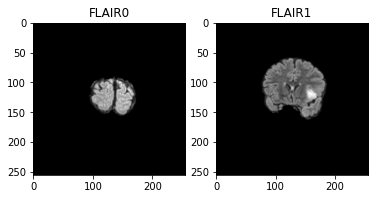

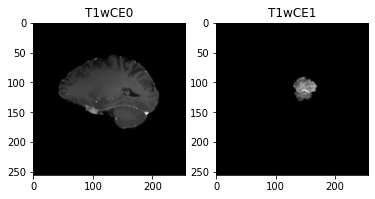

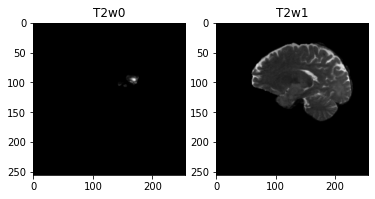

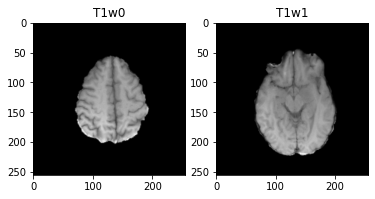

In [16]:
# plotting
for mri_type in mri_types:
    fig,axs=plt.subplots(1,2)
    imgs=final_img[mri_type][:2]
    for i,img in enumerate(imgs):
        axs[i].imshow(img,cmap='gray')
        axs[i].set_title(mri_type+str(i))
        
    

In [17]:
#dataset_dir='train'
#mini=99
#for file_id in tqdm(train_labels['BraTS21ID']):
 #   _,label,final_img=read_dicom_img(dataset_dir, file_id)
  #  mn=min(len(final_img['FLAIR']),
   #        len(final_img['T1w']),
    #       len(final_img['T1wCE']),
     #      len(final_img['T2w']))
    #if mn<mini:
     #   mini=mn
           
#mini   

## Train and Validation data 

In [18]:
#dataset_dir='train'
#dataset=np.array([read_dicom_img(dataset_dir, file_id)[0] for file_id in tqdm(train_labels['BraTS21ID'])])
#dataset_labels=train_labels['MGMT_value'].values 
#dataset=np.concatenate(dataset,axis=0)

In [19]:
#dataset.shape

In [20]:
#dataset=np.reshape(dataset,(-1,128,128,64))

In [21]:
#dataset.shape

In [22]:
#x_train,x_val,y_train,y_val=train_test_split(dataset,dataset_labels,test_size=0.04,random_state=42,shuffle=True)

In [23]:
#x_train.shape,x_val.shape

In [24]:
#x_train=tf.expand_dims(x_train,axis=-1)
#x_val=tf.expand_dims(x_val,axis=-1)


## Data Augmentation

In [25]:
@tf.function
def rescale(volume):
    def numpy_rescale(volume):
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    rescale_volume = tf.numpy_function(numpy_rescale, [volume], tf.float32)
    return rescale_volume
rescale=tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",seed=42),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.2),seed=42),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1, seed=42)    
])
    

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size=8
def prepare_train_validation(ds, shuffle=False, augment=False):
  # rescale all datasets
  #ds = ds.map(lambda x, y: (rescale(x), y), 
              #num_parallel_calls=AUTOTUNE)
  ds=ds.map(lambda x,y:(rescale(x,training=True),y),num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
  # expand last dimension
  ds=ds.map(lambda x,y:(tf.expand_dims(x,axis=-1),y),num_parallel_calls=AUTOTUNE)
  
    
  

  # Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
# train data and validation data
#train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#train_ds = prepare_train_validation(train_ds, shuffle=True, augment=False)
#val_ds = prepare_train_validation(val_ds)


In [28]:
#data = train_ds.take(1)
#images, labels = list(data)[0]
#images = images.numpy()
#print(images.shape)
#image = images[0]
#print("Dimension of the MRI scan is:", image.shape)
#plt.imshow(np.squeeze(image)[:,:,1], cmap="gray")

In [29]:
# model creation
width=256
height=256
depth=64
epochs=100
batch_size=16
# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
    
inputs =tf.keras.Input((width, height, depth, 1))
     
x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
    
x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
    
x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.01)(x)
    
x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x =tf.keras.layers.Dropout(0.02)(x)

x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.03)(x)

x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.04)(x)

x = tf.keras.layers.GlobalAveragePooling3D()(x)
x =tf.keras.layers.Dense(units=1024, activation="relu")(x)
x =tf.keras.layers.Dropout(0.08)(x)

outputs =tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

# Define the model.
model = tf.keras.Model(inputs, outputs, name="3dcnn")
# Compile model.
#initial_learning_rate = 0.0001
#lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
     #)
#model.compile(
       #loss="binary_crossentropy",
      #optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      #metrics=["acc"],
     #)


#model.fit(
    #x=x_train,y=y_train,
    #validation_data=(x_val,y_val),
    #epochs=epochs,
    #shuffle=True,
    #batch_size=batch_size,
    #verbose=2,
    #callbacks=[checkpoint_cb, early_stopping_cb],
#)
    

## Prediction

In [30]:
model.load_weights(model_weights)

In [31]:
dataset_dir='test'
test_prediction=[]
for file_id in tqdm(sample_df['BraTS21ID']):
    test_prediction.append(model.predict(np.expand_dims(read_dicom_img(dataset_dir, file_id)[0],axis=0))[0][0])
    

#test=np.array([read_dicom_img(dataset_dir, file_id)[0] for file_id in tqdm(sample_df['BraTS21ID'])])
#img=tf.expand_dims(img,axis=0)



  0%|          | 0/87 [00:00<?, ?it/s]2021-10-03 12:15:57.561011: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-03 12:15:57.572861: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz
2021-10-03 12:15:57.757811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-03 12:15:58.470303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-03 12:15:58.484038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
100%|██████████| 87/87 [02:16<00:00,  1.57s/it]


In [32]:
#prediction=[]
#for img in test:
    #pred=model.predict(test)
    #prediction.append(pred)
    


In [33]:
#from sklearn import metrics
#val_prediction=model.predict(x_val)
#y_val=np.array(y_val)
#fpr,tpr,threshold=metric.roc_curve(y_val,val_prediction)
#metrics.auc(fpr,tpr)

In [34]:
# modify sample df
sample_df['MGMT_value']=test_prediction
sample_df.head(20)

,BraTS21ID,MGMT_value
0,1,0.827251
1,13,0.777301
2,15,0.720657
3,27,0.701963
4,37,0.758207
5,47,0.765129
6,79,0.774154
7,80,0.734101
8,82,0.813746
9,91,0.776008


In [35]:
sample_df.to_csv('submission.csv',index=False)